In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
transition_probs = pd.read_csv('transition_probs.csv')

In [ ]:
## Build transition matrix
tr_pr = transition_probs.pivot_table(
    index='score_diff_state', 
    columns='next_score_diff_state', 
    values='prob',
    fill_value=0 # replace missing transitions with 0 probability
)

def extract_lower_bound(label):
    return float(label.strip('[]()').split(',')[0])

sorted_states = sorted(tr_pr.index, key=extract_lower_bound)

tr_pr = tr_pr.loc[sorted_states, sorted_states[::-1]]

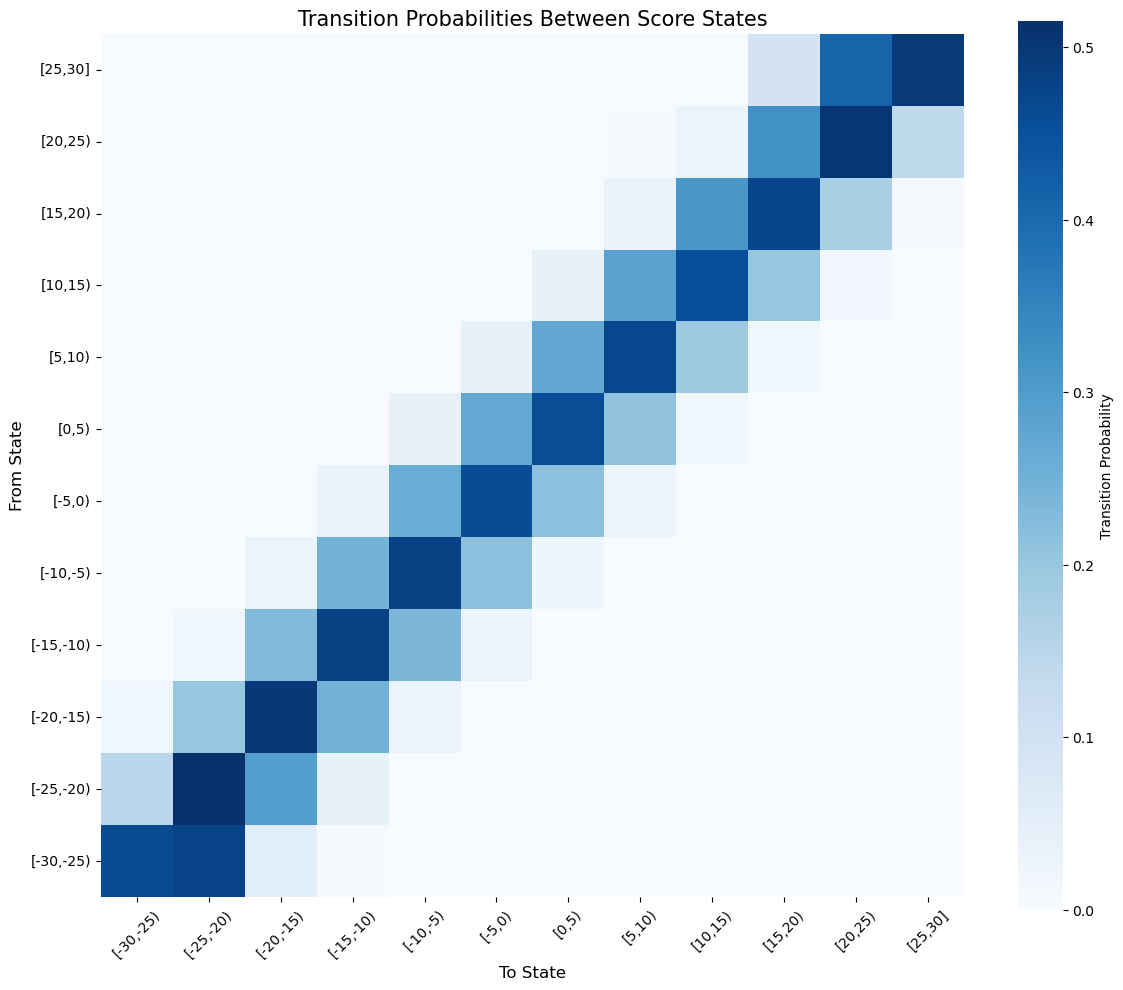

In [4]:
# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    tr_pr, 
    cmap='Blues',
    square=True,
    xticklabels=sorted_states,
    yticklabels=sorted_states[::-1],
    cbar_kws={'label': 'Transition Probability'}
)

plt.title('Transition Probabilities Between Score States', fontsize=15)
plt.xlabel('To State', fontsize=12)
plt.ylabel('From State', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()